# Analyzing Birth rate from World Bank Data using Agglomerative Clustering and Logistic Regression 

In [36]:
import pandas as pd
import numpy as np
import missingno as ms
import scipy.optimize as opt
import sklearn.cluster as cluster

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Dataset Loading

In [37]:
def function_transpose(file):
    '''
    this function will take a .csv file in the world bank format and transpose it into original
    format
    '''
    dataset=pd.read_csv(file)
    dataset=dataset.transpose()
    dataset.columns=dataset.iloc[0]
    dataset=dataset.iloc[:-1]
    dataset=dataset.reset_index()
    dataset=dataset.rename(columns={"index": "Year"})
    
    return dataset

file = 'countriesOfTheWorld-WDI.csv'
function_transpose(file)

Country,Year,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua & Barbuda,Argentina,...,Vanuatu,Venezuela,Vietnam,Virgin Islands,Wallis and Futuna,West Bank,Western Sahara,Yemen,Zambia,Zimbabwe
0,Country,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua & Barbuda,Argentina,...,Vanuatu,Venezuela,Vietnam,Virgin Islands,Wallis and Futuna,West Bank,Western Sahara,Yemen,Zambia,Zimbabwe
1,Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,OCEANIA,WESTERN EUROPE,SUB-SAHARAN AFRICA,LATIN AMER. & CARIB,LATIN AMER. & CARIB,LATIN AMER. & CARIB,...,OCEANIA,LATIN AMER. & CARIB,ASIA (EX. NEAR EAST),LATIN AMER. & CARIB,OCEANIA,NEAR EAST,NORTHERN AFRICA,NEAR EAST,SUB-SAHARAN AFRICA,SUB-SAHARAN AFRICA
2,Population,31056997,3581655,32930091,57794,71201,12127071,13477,69108,39921833,...,208869,25730435,84402966,108605,16025,2460492,273008,21456188,11502010,12236805
3,Area (sq. mi.),647500,28748,2381740,199,468,1246700,102,443,2766890,...,12200,912050,329560,1910,274,5860,266000,527970,752614,390580
4,Pop. Density (per sq. mi.),"48,0","124,6","13,8","290,4","152,1","9,7","132,1","156,0","14,4",...,"17,1","28,2","256,1","56,9","58,5","419,9","1,0","40,6","15,3","31,3"
5,Coastline (coast/area ratio),"0,00","1,26","0,04","58,29","0,00","0,13","59,80","34,54","0,18",...,"20,72","0,31","1,05","9,84","47,08","0,00","0,42","0,36","0,00","0,00"
6,Net migration,"23,06","-4,93","-0,39","-20,71","6,6",0,"10,76","-6,15","0,61",...,0,"-0,04","-0,45","-8,94",NaN,"2,98",NaN,0,0,0
7,Infant mortality (per 1000 births),"163,07","21,52",31,"9,27","4,05","191,19","21,03","19,46","15,18",...,"55,16","22,2","25,95","8,03",NaN,"19,62",NaN,"61,5","88,29","67,69"
8,GDP ($ per capita),700,4500,6000,8000,19000,1900,8600,11000,11200,...,2900,4800,2500,17200,3700,800,NaN,800,800,1900
9,Literacy (%),"36,0","86,5","70,0","97,0","100,0","42,0","95,0","89,0","97,1",...,"53,0","93,4","90,3",NaN,"50,0",NaN,NaN,"50,2","80,6","90,7"


In [38]:
dataset = pd.read_csv('countriesOfTheWorld-WDI.csv')

## Data Pre-processing
### Lets see the missing values first and then fix those outliers. This time I am using a library names "missingno", It will show the missing values in a viusal effects. We will then analyze the missing values in each features and then try to fix those.

<function matplotlib.pyplot.show(*args, **kw)>

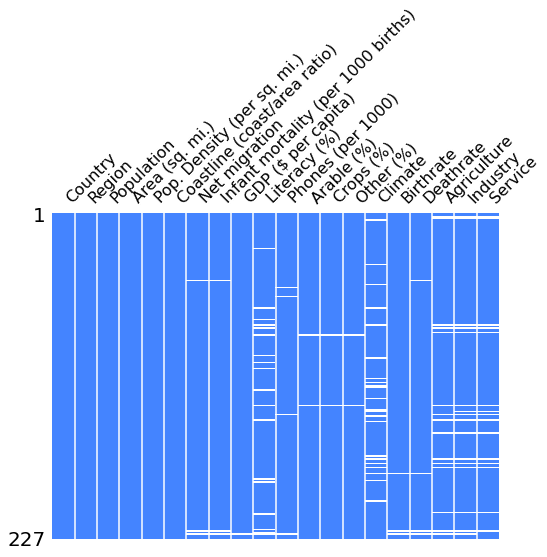

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
ms.matrix(dataset, ax=ax, sparkline=False, color=(0.27, 0.52, 1.0))
plt.show

The matrix plot is showing the missing values trend in every feature. As it is visible that some of the features, For example Agriculture, Industry and Service; are showing missing values in the same country (the straight line). Let fill these missing feature values with the mean value of the respective column.

In [53]:
dataset.fillna(dataset.mean(), inplace=True)

In [54]:
dataset.isnull().sum()

Country                               0
Region                                0
Population                            0
Area (sq. mi.)                        0
Pop. Density (per sq. mi.)            0
Coastline (coast/area ratio)          0
Net migration                         0
Infant mortality (per 1000 births)    0
GDP ($ per capita)                    0
Literacy (%)                          0
Phones (per 1000)                     0
Arable (%)                            0
Crops (%)                             0
Other (%)                             0
Climate                               0
Birthrate                             0
Deathrate                             0
Agriculture                           0
Industry                              0
Service                               0
dtype: int64

In [55]:
columns = dataset[['Net migration', 'Deathrate', 'Agriculture', 'Industry', 'Service', 
                   'Infant mortality (per 1000 births)', 'Literacy (%)', 'Phones (per 1000)',
                   'Arable (%)', 'Crops (%)', 'Other (%)', 'Climate', 'Birthrate']]
def changetype(columns):
    '''
    This function is used in the coversion of the feature column types as 
    some are objects and some are floats. And replace all the , with the
    . in all numeric features for smooth visualizations.
    '''
    for i in columns:
        dataset[i] = dataset[i].astype(str)
        dataset1 = []
        for j in dataset[i]:
            j = j.replace(',','.')
            j = float(j)
            dataset1.append(j)
        dataset[i] = dataset1
changetype(columns)


In [56]:
# trim the spaces after and before the text. It can be seen from the sample 
# data, there are some spaces in some countries names.

dataset['Region'] = dataset.Region.str.strip()
dataset['Country'] = dataset.Country.str.strip()

In [57]:
df1 = dataset.copy() # copy dataset in df1
df2 = df1.drop(columns= ['Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)'],
               inplace = True ) # Drop the column Region as we will analysis the data with respect to country

# Dataset Normalization

In [58]:
def norm(array):
    """ Returns array normalised to [0,1]. Array can be a numpy array 
    or a column of a dataframe"""

    min_val = np.min(array)
    max_val = np.max(array)
    
    scaled = (array-min_val) / (max_val-min_val)
    
    return scaled


def norm_df(df):
    """ 
    Returns all columns of the dataframe normalised to [0,1] with the 
    exception the first (containing the names)
    Calls function norm to do the normalisation of one column, but
    doing all in one function is also fine. 
    """
    
    # iterate over all columns
    for col in df.columns[2:]:     # excluding the first column
        df[col] = norm(df[col])
        
    return df


In [59]:
df1 = norm_df(df1)

# Number of countries in each region

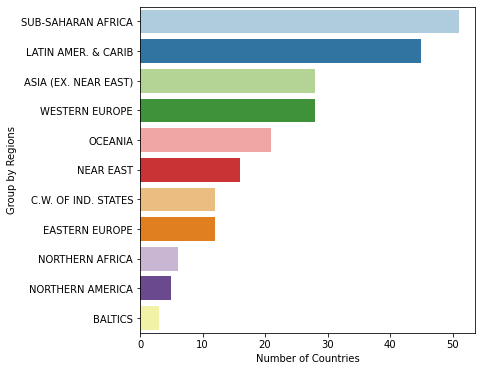

In [60]:
import seaborn as sns

country = df1['Region'].value_counts()
plt.figure(figsize=(6,6,))
sns.barplot(y=country.index,x=country.values, palette="Paired")
plt.xlabel('Number of Countries')
plt.ylabel('Group by Regions')
plt.show()

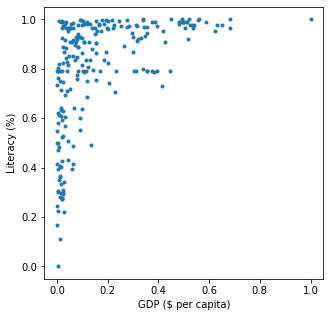

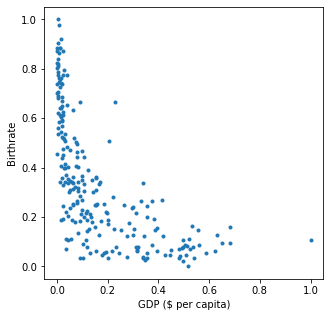

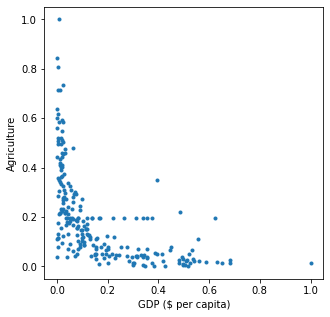

In [61]:
def makeplot(df, col1, col2):
    """
    Produces a square plot of two columns of dataframe df using small circle 
    symbols.
    """
    
    plt.figure(figsize=(5.0,5.0))
    plt.plot(df[col1], df[col2], "o", markersize=3)
    
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()
    
    
# exploratory plots
makeplot(df1, "GDP ($ per capita)", "Literacy (%)")
makeplot(df1, "GDP ($ per capita)", "Birthrate")
makeplot(df1, "GDP ($ per capita)", "Agriculture")


# K-means Clustering

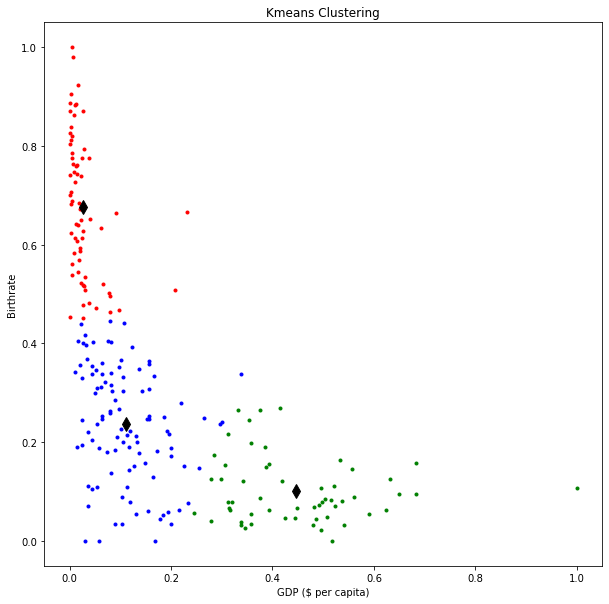

In [54]:
####### kmeans set up the clusterer, 4 expected clusters
kmeans = cluster.KMeans(n_clusters=3)

# extract columns for fitting
df_fit = df1[[ "GDP ($ per capita)", "Birthrate"]].copy()
kmeans.fit(df_fit)     

# extract labels and cluster centres
labels = kmeans.labels_
cen = kmeans.cluster_centers_

# plot using the labels to select colour
plt.figure(figsize=(10,10))

col = ["blue", "red", "green", "magenta", "yellow", "red"]
for l in range(3):     # loop over the different labels
    plt.plot(df_fit["GDP ($ per capita)"][labels==l], df_fit["Birthrate"][labels==l], "o", markersize=3, color=col[l])
    
# show cluster centres
for ic in range(3):
    xc, yc = cen[ic,:]
    plt.plot(xc, yc, "dk", markersize=10)

plt.title("Kmeans Clustering")    
plt.xlabel("GDP ($ per capita)")
plt.ylabel("Birthrate")
plt.show()

# Agglomerative Clustering

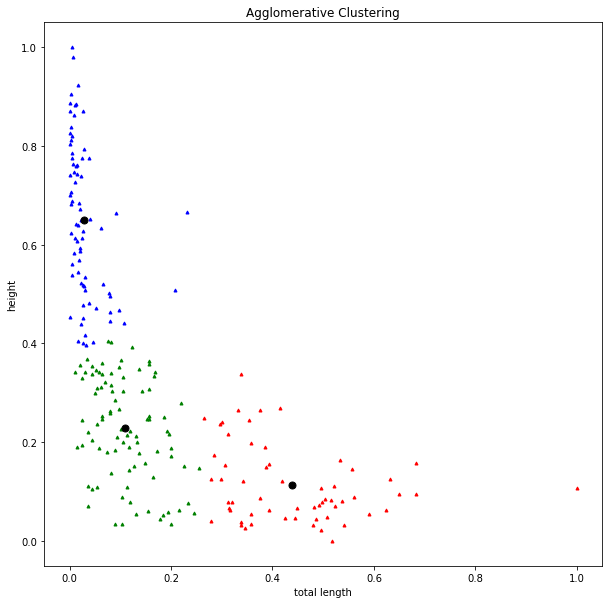

In [66]:
##### setting up agglomerative clustering for 6 clusters
ac = cluster.AgglomerativeClustering(n_clusters=3)

# carry out the fitting
df_fit = df1[[ "GDP ($ per capita)", "Birthrate"]].copy()
ac.fit(df_fit)

labels = ac.labels_

# The clusterer does not return cluster centres, but they are easily computed
xcen = []
ycen = []
for ic in range(3):
    xc = np.average(df_fit["GDP ($ per capita)"][labels==ic])
    yc = np.average(df_fit["Birthrate"][labels==ic])
    xcen.append(xc)
    ycen.append(yc)

# plot using the labels to select colour
plt.figure(figsize=(10,10))

col = ["blue", "red", "green", "magenta","yellow","aqua"]
for l in range(0,3):     # loop over the different labels
    plt.plot(df_fit["GDP ($ per capita)"][labels==l], df_fit["Birthrate"][labels==l], "^", markersize=3, color=col[l])
    
# show cluster centres
for ic in range(3):
    plt.plot(xcen[ic], ycen[ic], ".", markersize=14, color = "k")

plt.title("Agglomerative Clustering")     
plt.xlabel("total length")
plt.ylabel("height")
plt.show()


###### writing labels into df_fish, sorting and exporting as excel file
df1["labels"] = labels
df1 = df1.sort_values(["labels"], ignore_index=True)
#df.to_excel("fish_clusters.xlsx")

# Data Fitting

In [27]:
from sklearn.linear_model import LinearRegression
data = pd.read_csv("WDI_country.csv")
data

,year,Population,Birthrate % Change
0,1950,376325200,NaN
1,1951,382376948,1.61
2,1952,388799073,1.68
3,1953,395544369,1.73
4,1954,402578596,1.78
...,...,...,...
63,2013,1280842125,1.19
64,2014,1295600772,1.15
65,2015,1310152403,1.12
66,2016,1324517249,1.10


In [28]:
"""
Define the logistics functions for fitting.
"""
  
def logistics(t, scale, growth, t0):
    """ Computes logistics function with scale, growth raat
    and time of the turning point as free parameters
    """
    
    f = scale / (1.0 + np.exp(-growth * (t - t0)))
    
    return f
        

Fit parameter [2.52480676e+09 2.96170675e-02 2.01171142e+03]


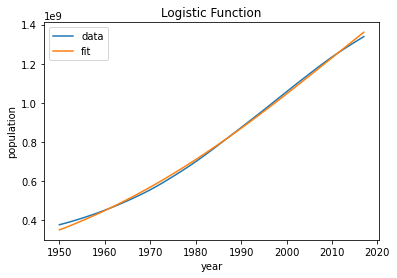

In [29]:
"""
fit the logistics function with some initial parameters such as p0. It will give us much better results 
fit logistic growth and then calculate/ plot the result. 
"""

# fit exponential growth
p, c = opt.curve_fit(logistics, data["year"], data["Population"], p0=(2e9, 0.05, 1990.0))
# much better
print("Fit parameter", p)

data["logistic"] = logistics(data["year"], *p)

plt.figure()
plt.plot(data["year"], data["Population"], label="data")
plt.plot(data["year"], data["logistic"], label="fit")

plt.legend()
plt.xlabel("year")
plt.ylabel("population")
plt.title("Logistic Function")
plt.show()
print()


# err_ranges()

In [30]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   



[9.44349836e+07 6.01576537e-04 2.44923945e+00]


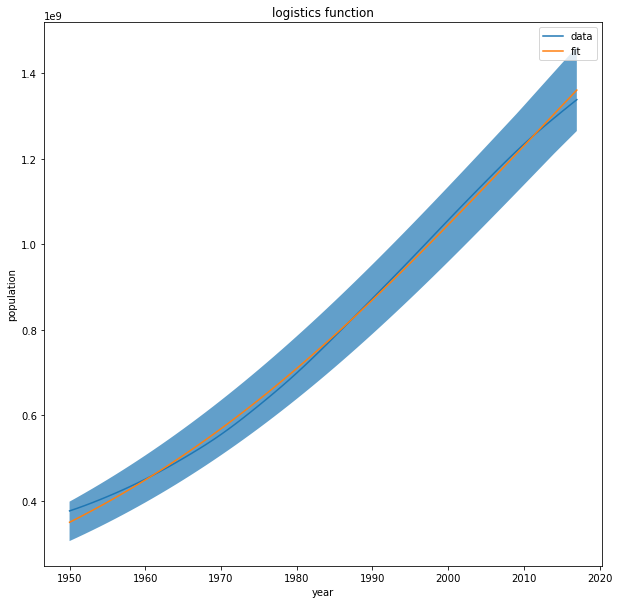

In [34]:
# extract the sigmas from the diagonal of the covariance matrix
sigma = np.sqrt(np.diag(c))
print(sigma)

low, up = err_ranges(data["year"], logistics, p, sigma)

plt.figure(figsize=(10,10))
plt.title("logistics function")
plt.plot(data["year"], data["Population"], label="data")
plt.plot(data["year"], data["logistic"], label="fit")

plt.fill_between(data["year"], low, up, alpha=0.7)
plt.legend()
plt.xlabel("year")
plt.ylabel("population")
plt.show()


## Prediction of the Population  

In [32]:
# Give Ranges

print("Forcasted population")
low, up = err_ranges(2030, logistics, p, sigma)
print("2030 between ", low, "and", up)
low, up = err_ranges(2040, logistics, p, sigma)
print("2040 between ", low, "and", up)
low, up = err_ranges(2050, logistics, p, sigma)
print("2050 between ", low, "and", up)

Forcasted population
2030 between  1489613748.4262006 and 1707048163.5899236
2040 between  1650519621.8621323 and 1877585012.4929025
2050 between  1795631427.8485541 and 2027295272.1060772
